In [1]:
import os
import warnings
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
from dotenv import load_dotenv
from scipy.stats import bootstrap, ks_2samp, kstest, shapiro

from clean import clean_data
from eda import calculate_psi
from feature_engineering import feature_engineering, missing_values, plot_transformed
from math_statistic import *

# Загрузка переменных окружения из файла .env
load_dotenv()

warnings.filterwarnings("ignore")
%matplotlib inline

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

#### Общая информация о данных


Датасет представляет собой спарсенный сайт одной известной площадки.


Столбцы:

- **price** - цена ноутбука в руб.

- **bonus** - начисляемый кэшбэк в руб.

- **credit** - ежемесячная сумма кредита 

- **title** - название ноутбука 

- **review** - количество отзывов


- **merchant_name** - полное название продавца

- **brands** - бренд ноутбука

- **manufacturer** - название продавца


- **loan_closure** - предполагаемый срок погашения кредита в месяцах

В данной работе будем работать только с наиболее популярными брендами 

#### Этапы работы:

1. **Сбор данных:**
   - Для сбора данных был выбран инструмент `Selenium`, поскольку маркетплейс не предоставлял возможности простого парсинга. Дополнительно, для обхода защиты и получения данных в формате JavaScript, использовался Selenium. Для выполнения скриптов был выбран браузер Chrome последней версии, а также установлен ChromeDriver. Собранные данные не подвергались очистке и сохранялись в исходном формате.

2. **Работа с базой данных:**
   - Для хранения данных была использована база данных `PostgreSQL`, размещенная на виртуальной машине от Yandex Cloud. В файле .env хранятся реальные настройки для подключения к серверу (включая учетные данные). Настройки базы данных включали:
     - Создание базы данных и таблиц, а также заполнение их данными.
     - Настройка привилегий доступа, включая создание и удаление привилегий по умолчанию.
     - Создание пользователя `timur` с минимальными привилегиями: разрешение только на подключение к базе данных и выполнение операции `SELECT` только для таблицы `laptops`.

3. **Предварительная обработка данных:**
   - В этом этапе происходила загрузка данных из источника, их очистка и преобразование, а также создание новых признаков.
   - Осуществлялось заполнение пропущенных значений в данных и предварительный анализ признаков.
   - Также проводились простые статистические тесты для определения распределения данных и анализа описательной статистики.



4. **Статические тесты**
   - В этом этапе проводились различные статистические тесты для проверки гипотез и выявления закономерностей в данных.
   - Тесты включали в себя t-тесты для сравнения средних значений двух выборок, анализ дисперсии (ANOVA) для сравнения средних значений между несколькими группами, Пермутационный тест, критерий Манна-Уитни и корреляционный анализ для оценки связи между переменными, а также другие статистические методы.

   - Результаты тестов использовались для подтверждения или опровержения гипотез о взаимосвязи между различными переменными в данных.
   - После проведения статистических тестов полученные результаты анализировались и интерпретировались с учетом контекста и целей исследования.

In [2]:
# Загрузка необходимых переменных из .env для подключение к БД
USER = os.environ["USER"]
PASSWORD_USER = os.environ["PASSWORD_USER"]
HOST = os.environ["HOST"]
DATABASE = os.environ["DATABASE"]
PORT = os.environ["PORT"]

In [3]:
# try:

#     # Подключение к базе данных postgresql
#     connection = psycopg2.connect(
#         user=USER, password=PASSWORD_USER, host=HOST, port=PORT, database=DATABASE
#     )

#     # Запрос к таблице
#     query = "SELECT * FROM laptop"

#     df = pd.read_sql(query, connection)
#     df.to_csv("table_laptops.csv", index=False)


# except (Exception, psycopg2.Error) as error:
#     print("Error connecting to PostgreSQL:", error)

# finally:
#     # Закрываем соединение с базой данных
#     if connection:
#         connection.close()
#         print("PostgreSQL connection is closed")

In [2]:
df = pd.read_csv("table_laptops.csv")
df.head()

,id,price,bonus,credit,title,review,merchant_name
0,1,79 990 ₽,11 999,2 273 ₽,Ноутбук Huawei MateBook B3-520 Gray (53013fcn),17.0,Мегамаркет Москва Пушкино
1,2,118 202 ₽,17 731,3 359 ₽,Ноутбук Acer Nitro 5 AN515-58 Black (NH.QLZCD....,10.0,Мегамаркет Москва Томилино
2,3,94 990 ₽,14 249,2 700 ₽,"Ноутбук Apple MacBook Air 13"" M1/8Gb/256Gb/Spa...",999.0,Мегамаркет Москва Пушкино
3,4,40 990 ₽,2 870,1 165 ₽,Ноутбук Lenovo IdeaPad Slim 3 15IRU8 Gray,97.0,Ситилинк Москва Доставка
4,5,51 490 ₽,8 239,1 463 ₽,Ноутбук Honor MagicBook X16 2024 DOS Gray (530...,71.0,Click & Buy (со склада МегаМаркет)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             13584 non-null  int64  
 1   price          13562 non-null  object 
 2   bonus          6021 non-null   object 
 3   credit         12590 non-null  object 
 4   title          13563 non-null  object 
 5   review         12708 non-null  float64
 6   merchant_name  13563 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 743.0+ KB


In [4]:
# очистка данных
df = clean_data(df)

# заполнение пропусков в данных
df = missing_values(df)

# создание новых признаков/метрик
df = feature_engineering(df)

df.head()

,price,bonus,credit,title,review,merchant_name,brands,manufacturer,loan_closure
0,79990.0,11999.0,2273.0,Ноутбук Huawei MateBook B3-520 Gray (53013fcn),17.0,Мегамаркет Москва Пушкино,Huawei,Мегамаркет,36
1,118202.0,17731.0,3359.0,Ноутбук Acer Nitro 5 AN515-58 Black (NH.QLZCD....,10.0,Мегамаркет Москва Томилино,Acer,Мегамаркет,36
2,94990.0,14249.0,2700.0,"Ноутбук Apple MacBook Air 13"" M1/8Gb/256Gb/Spa...",999.0,Мегамаркет Москва Пушкино,Apple,Мегамаркет,36
3,40990.0,2870.0,1165.0,Ноутбук Lenovo IdeaPad Slim 3 15IRU8 Gray,97.0,Ситилинк Москва Доставка,Lenovo,Ситилинк,36
4,51490.0,8239.0,1463.0,Ноутбук Honor MagicBook X16 2024 DOS Gray (530...,71.0,Click & Buy (со склада МегаМаркет),Honor,Click,36


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9484 entries, 0 to 10007
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          9484 non-null   float64
 1   bonus          9484 non-null   float64
 2   credit         9484 non-null   float64
 3   title          9484 non-null   object 
 4   review         9484 non-null   float64
 5   merchant_name  9484 non-null   object 
 6   brands         9484 non-null   object 
 7   manufacturer   9484 non-null   object 
 8   loan_closure   9484 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 740.9+ KB


#### Теория вероятностей и мат. статистика

1. Анализ датасета на предмет распределений признаков

In [6]:
# Описательная статистика
df.describe(include="all").round(2)

,price,bonus,credit,title,review,merchant_name,brands,manufacturer,loan_closure
count,9484.00,9484.00,9484.00,9484,9484.00,9484,9484,9484,9484.00
unique,NaN,NaN,NaN,891,NaN,313,26,248,NaN
top,NaN,NaN,NaN,Ноутбук Infinix InBook Y3 Max YL613 Silver,NaN,Alt-Dim,ASUS,Alt-Dim,NaN
freq,NaN,NaN,NaN,72,NaN,401,2017,401,NaN
mean,99836.73,9956.06,2627.20,NaN,29.24,NaN,NaN,NaN,40.71
std,64520.72,6502.72,1478.25,NaN,86.21,NaN,NaN,NaN,28.65
min,15999.00,348.00,455.00,NaN,1.00,NaN,NaN,NaN,14.00
25%,55195.25,8400.00,1563.00,NaN,4.00,NaN,NaN,NaN,36.00
50%,78213.00,8400.00,2038.00,NaN,12.00,NaN,NaN,NaN,36.00
75%,130640.00,8400.00,3558.25,NaN,26.00,NaN,NaN,NaN,36.00


In [9]:
df.brands.value_counts()

brands
ASUS           2017
Apple          1069
Lenovo          985
Acer            926
Huawei          752
GIGABYTE        617
MSI             560
Tecno           389
MAIBENBEN       311
Infinix         301
HP              274
Honor           243
DIGMA           220
iRU             112
Machenike       103
Chuwi            97
Azerty           92
Xiaomi           66
Colorful         61
HIPER            60
IRBIS            53
Samsung          50
Dell             39
F                32
Thunderobot      28
OSIO             27
Name: count, dtype: int64

#### Ящик с усами

In [11]:
# Список метрик
metrics_list = ["price", "bonus", "credit", "review", "loan_closure"]

brands = [
    "ASUS",
    "Apple",
    "Lenovo",
    "Acer",
    "Huawei",
    "GIGABYTE",
    "MSI",
    "Tecno",
    "MAIBENBEN",
    "Infinix",
    "HP",
    "Honor",
    "DIGMA",
]



brands_graf = [
    "ASUS",
    "Apple",
    "Lenovo",
    "Acer",
    "Huawei",
    "GIGABYTE",
]

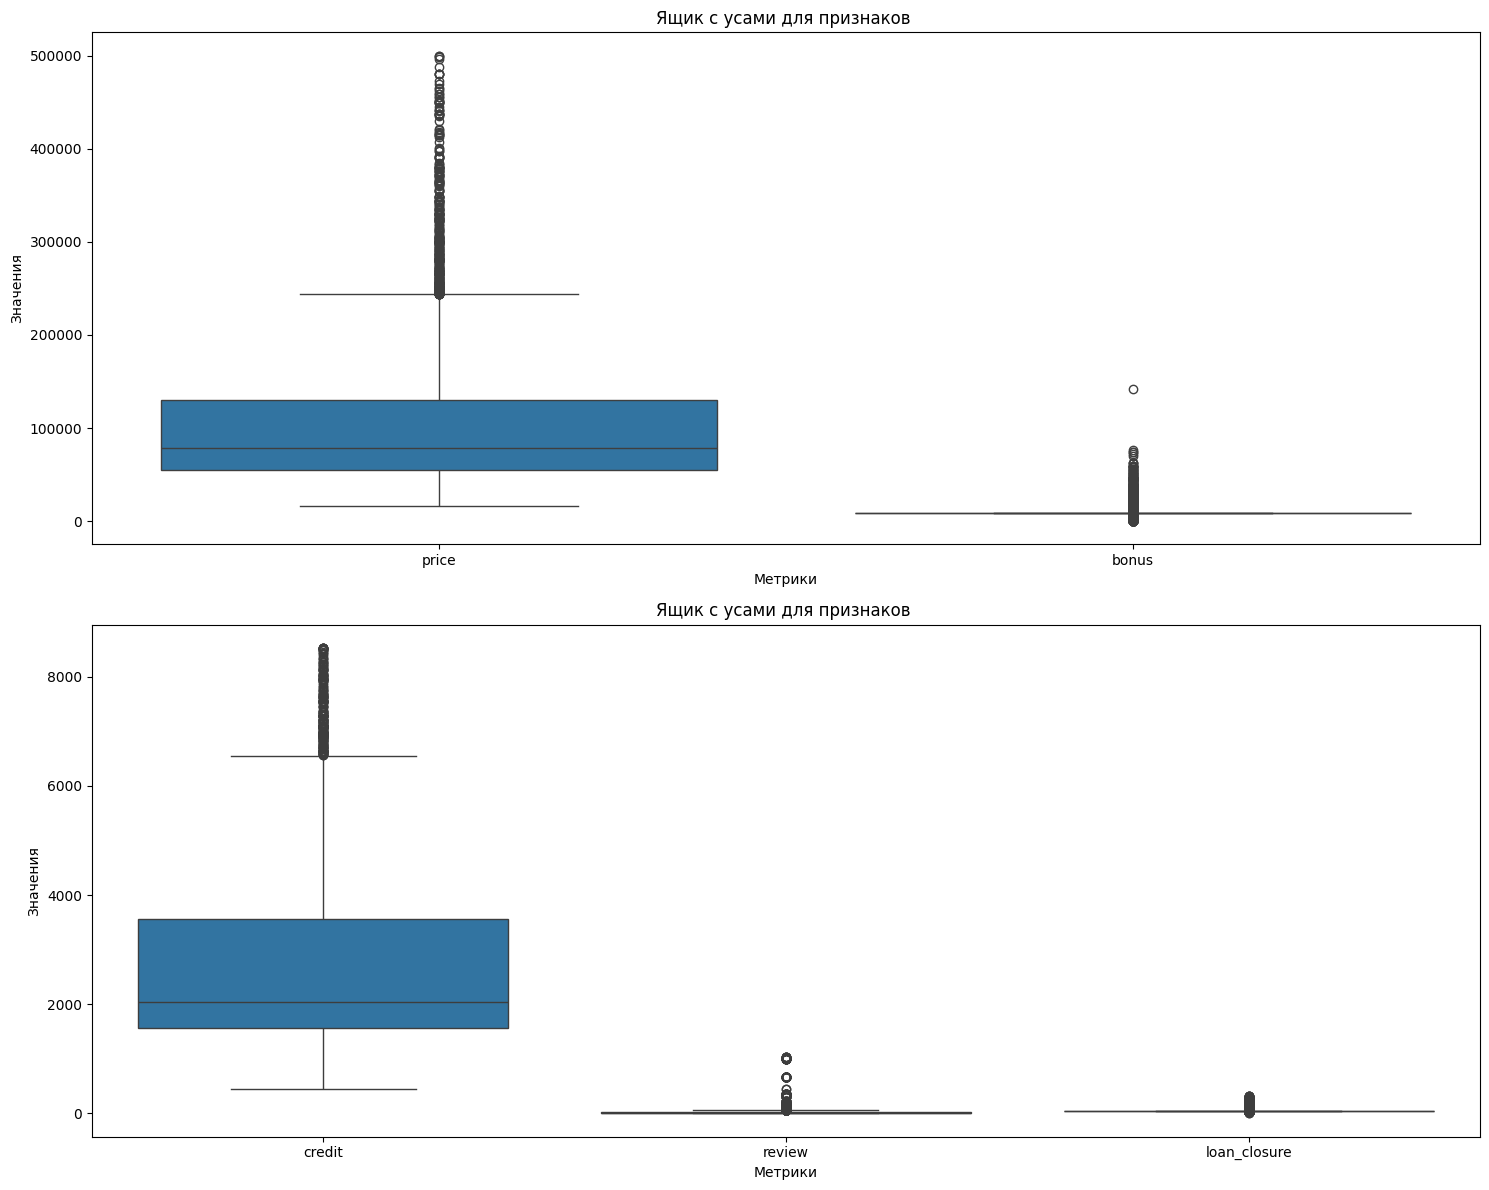

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

axes[0].set_title("Ящик с усами для признаков ")
axes[0].set_xlabel("Метрики")
axes[0].set_ylabel("Значения")
sns.boxplot(data=df[metrics_list[:2]], orient="v", ax=axes[0])

axes[1].set_title("Ящик с усами для признаков ")
axes[1].set_xlabel("Метрики")
axes[1].set_ylabel("Значения")
sns.boxplot(data=df[metrics_list[2:]], orient="v", ax=axes[1])

plt.tight_layout()
plt.show()

#### Гистограмма признаков относительна бренда ноутбука

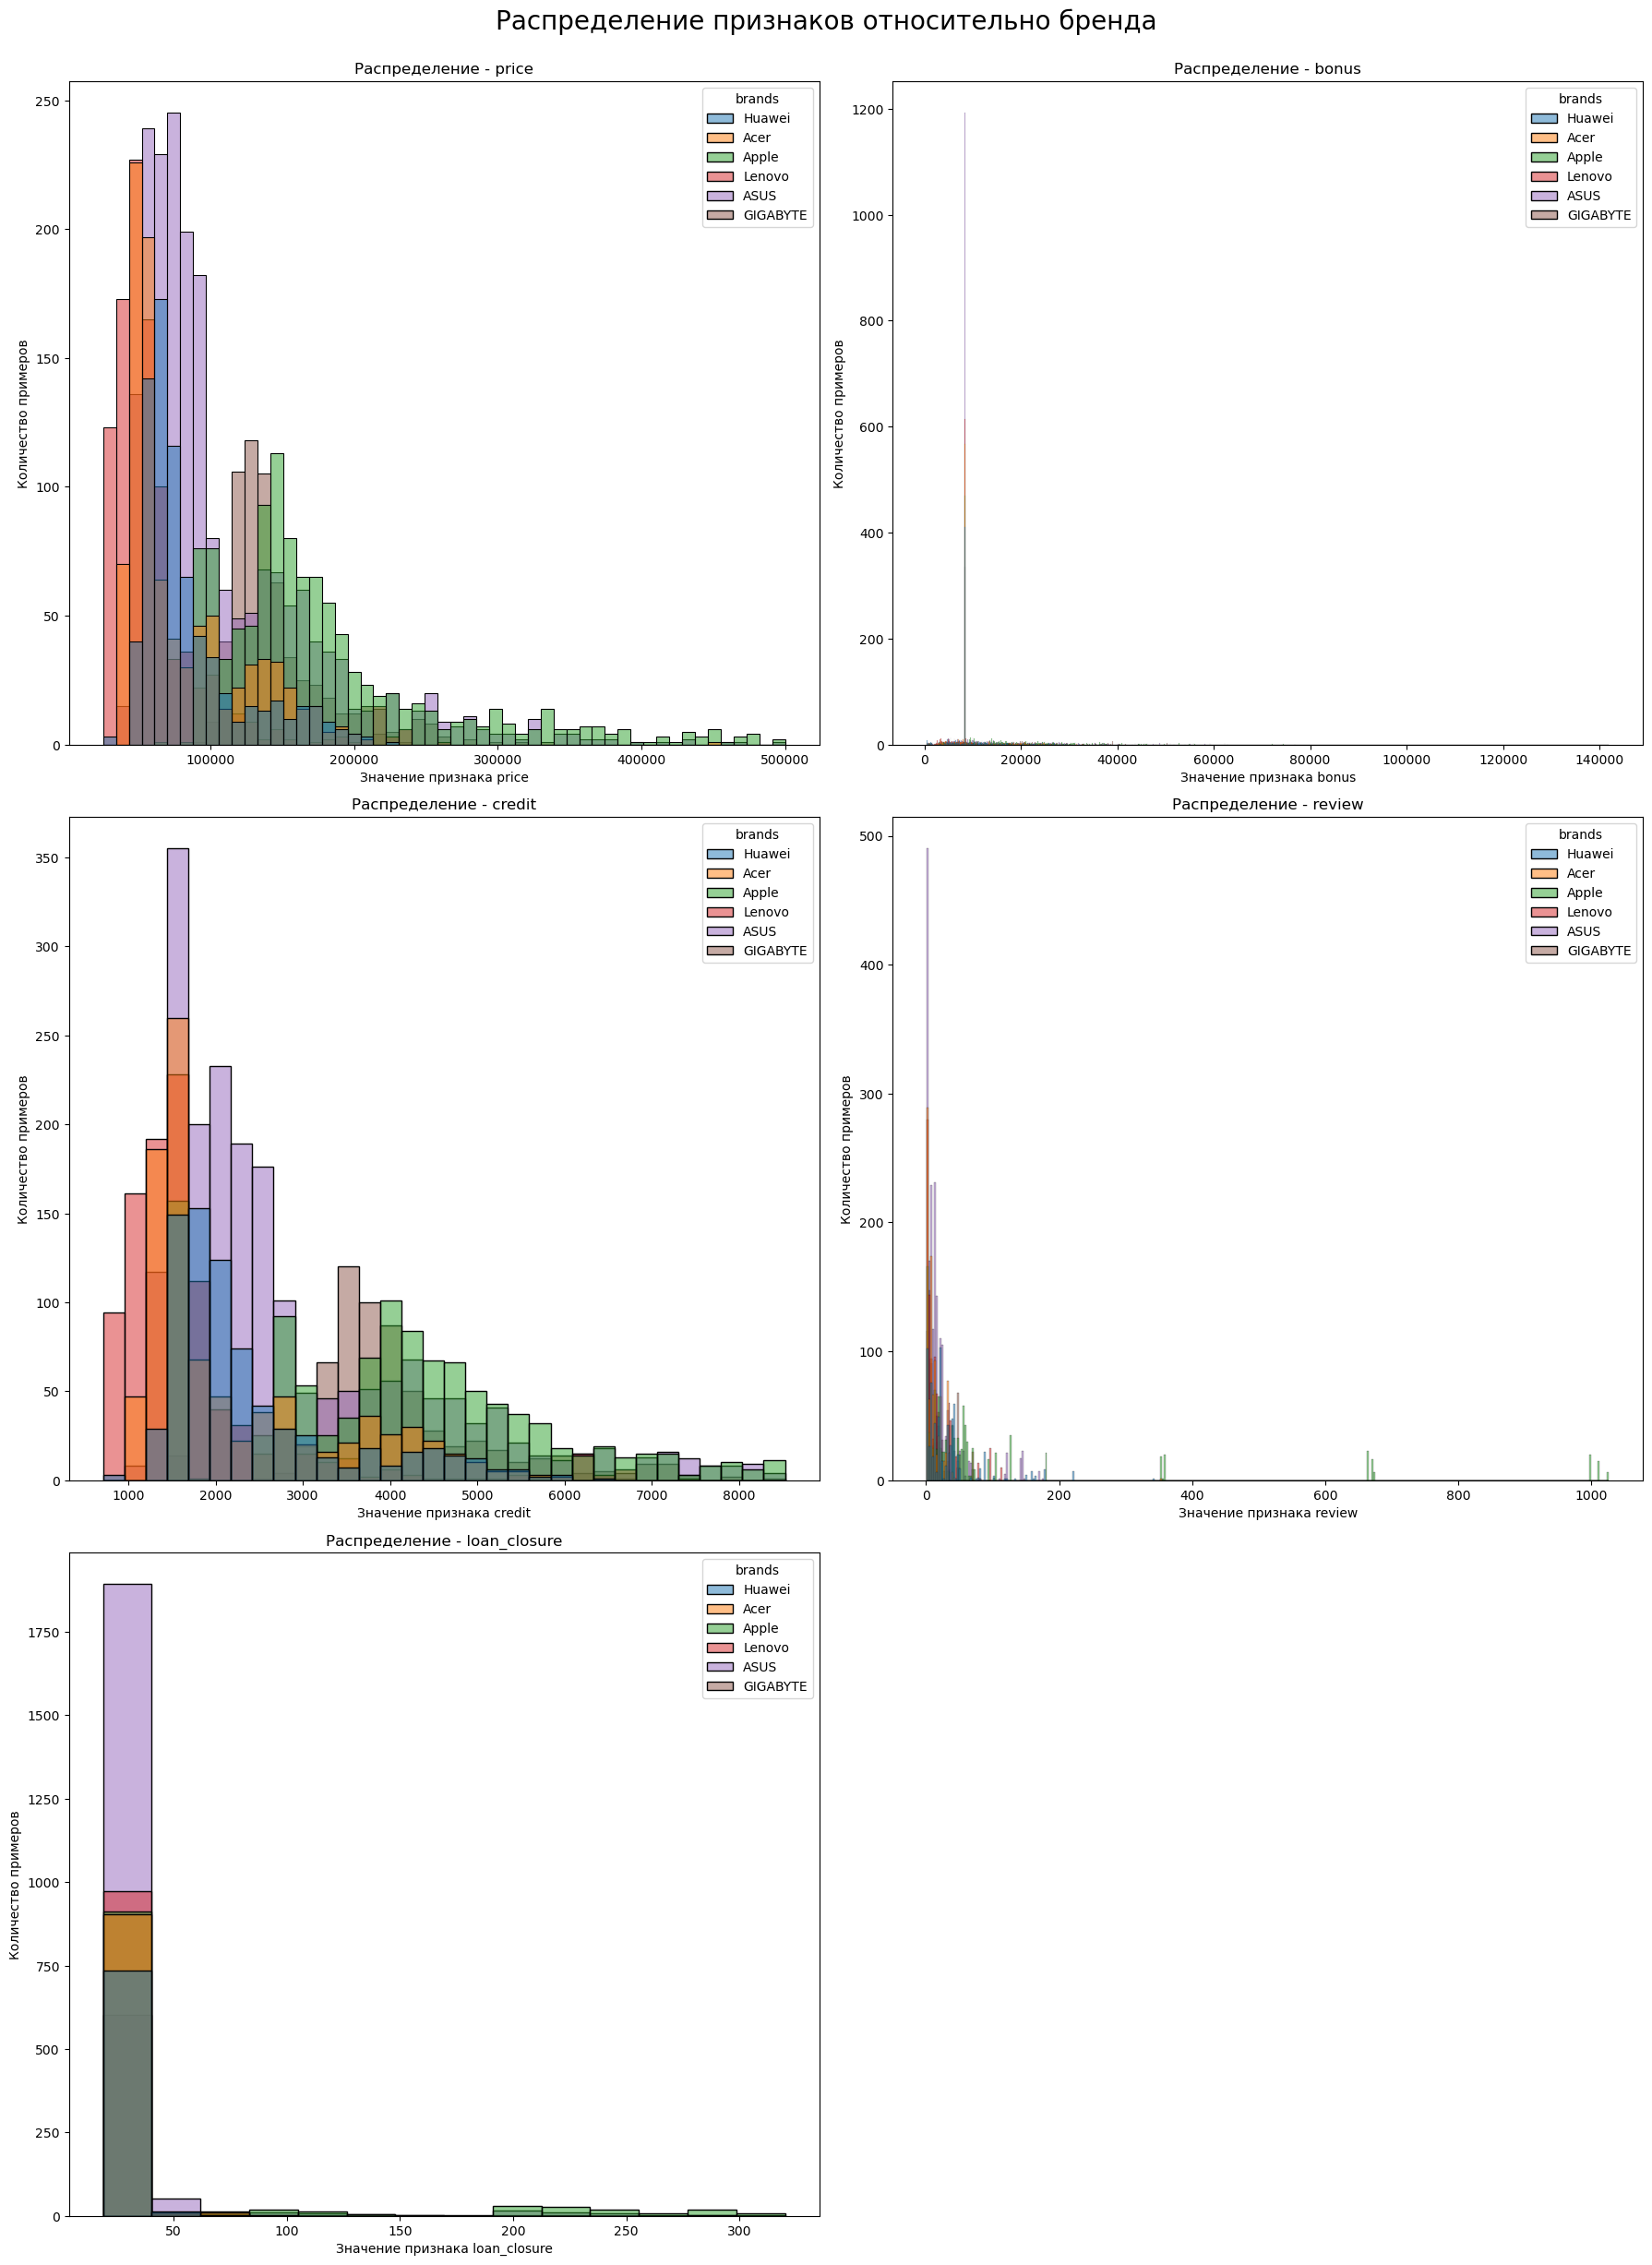

In [12]:
# Рассмотрим распределение признаков относительно Бренда ноутбука(рассмотрим только самые популярные бренды)

plt.figure(figsize=(18, 40))
plt.suptitle("Распределение признаков относительно бренда", fontsize=20, x=0.5, y=1)
for i, column in enumerate(metrics_list):
    plt.subplot(len(metrics_list), 2, i + 1)
    sns.histplot(data=df[df['brands'].isin(brands_graf)], x=column, kde=False, hue="brands")
    plt.title(f"Распределение - {column}")
    plt.xlabel(f"Значение признака {column}")
    plt.ylabel("Количество примеров")

    plt.tight_layout()

#### Стат. тесты для преобразованных данных 

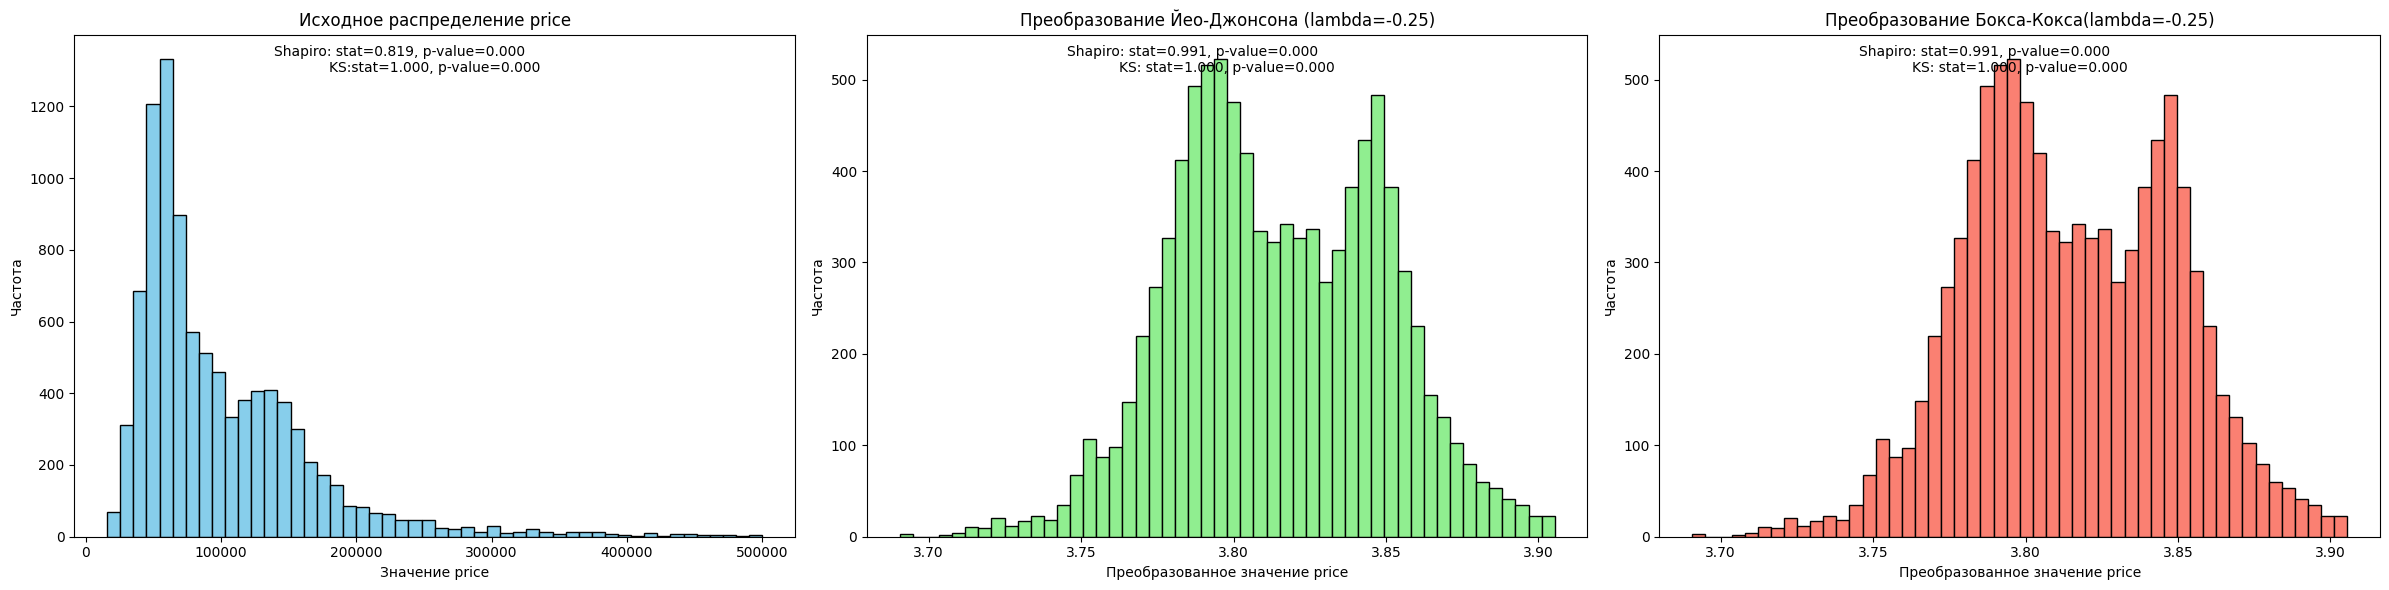

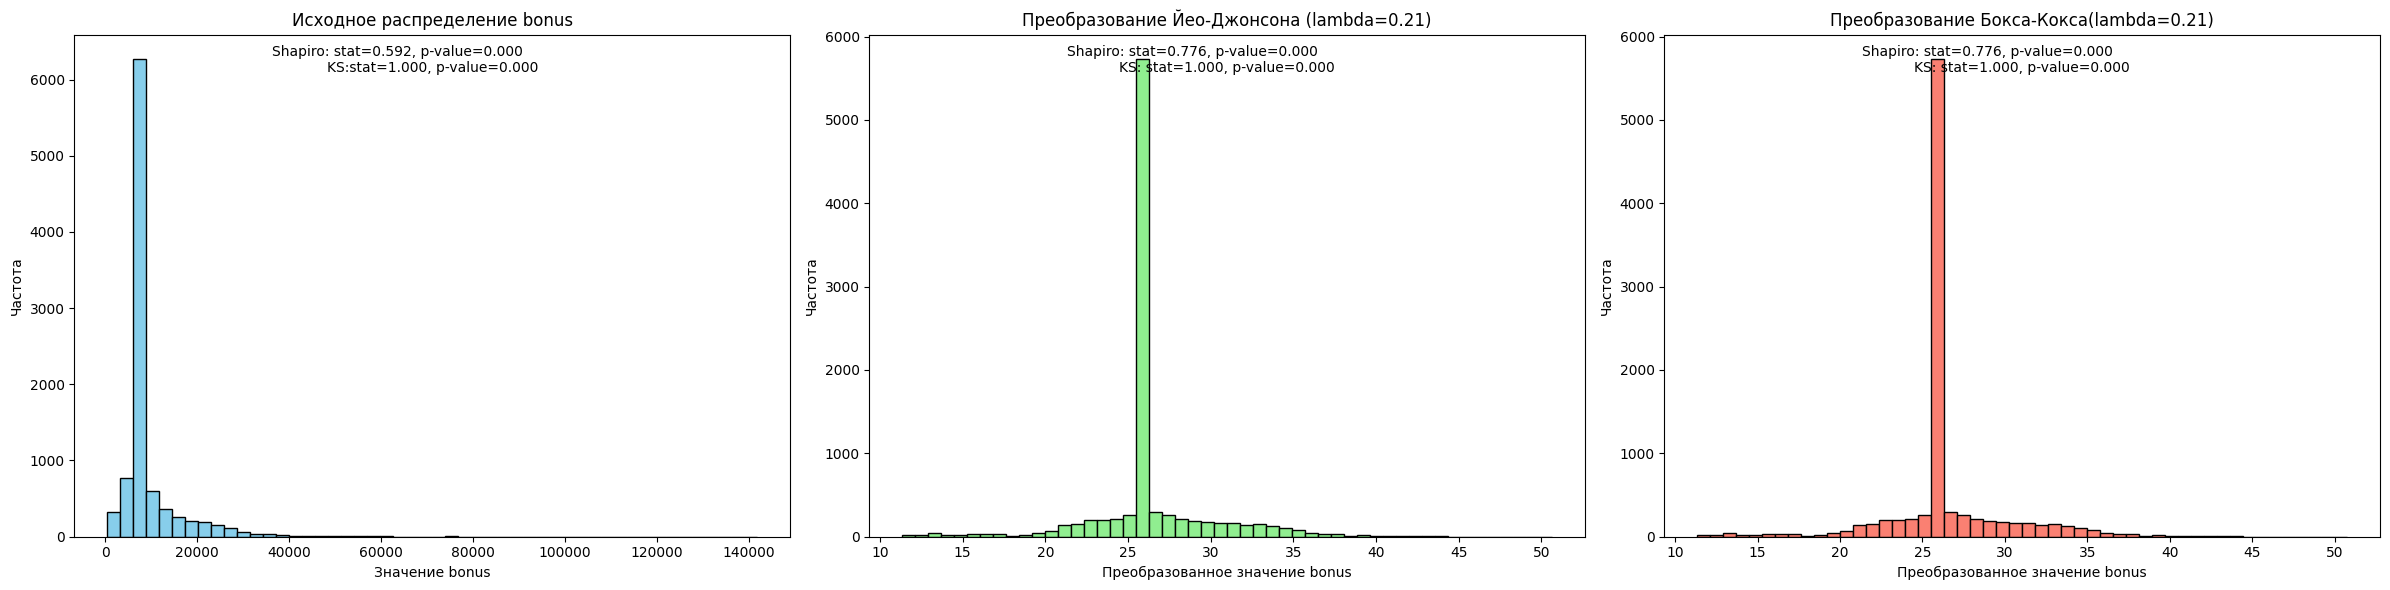

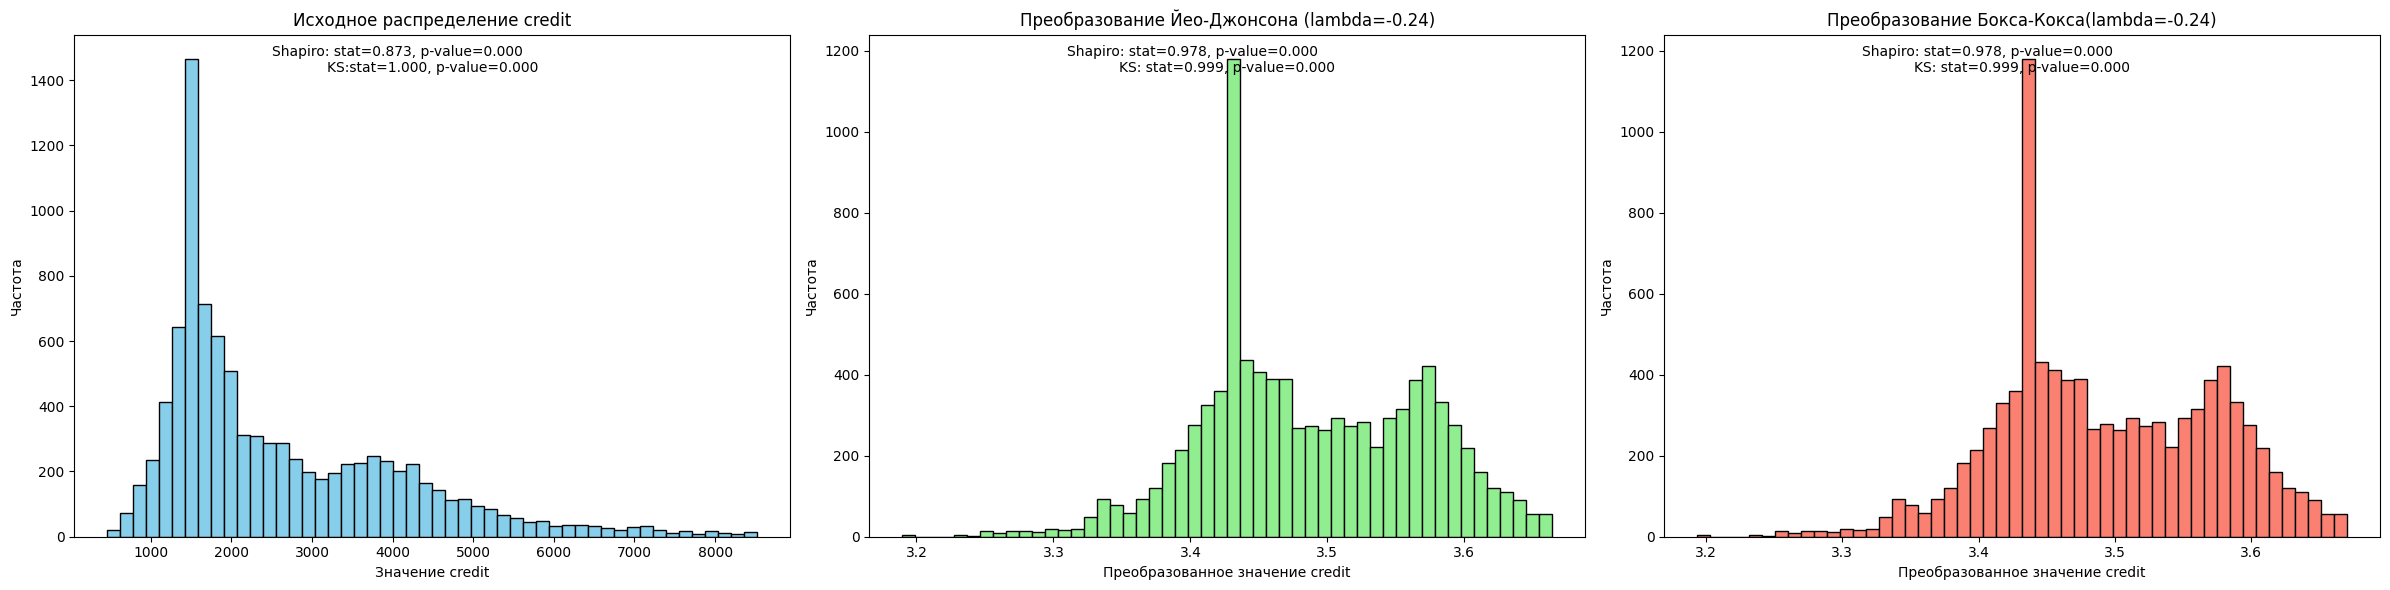

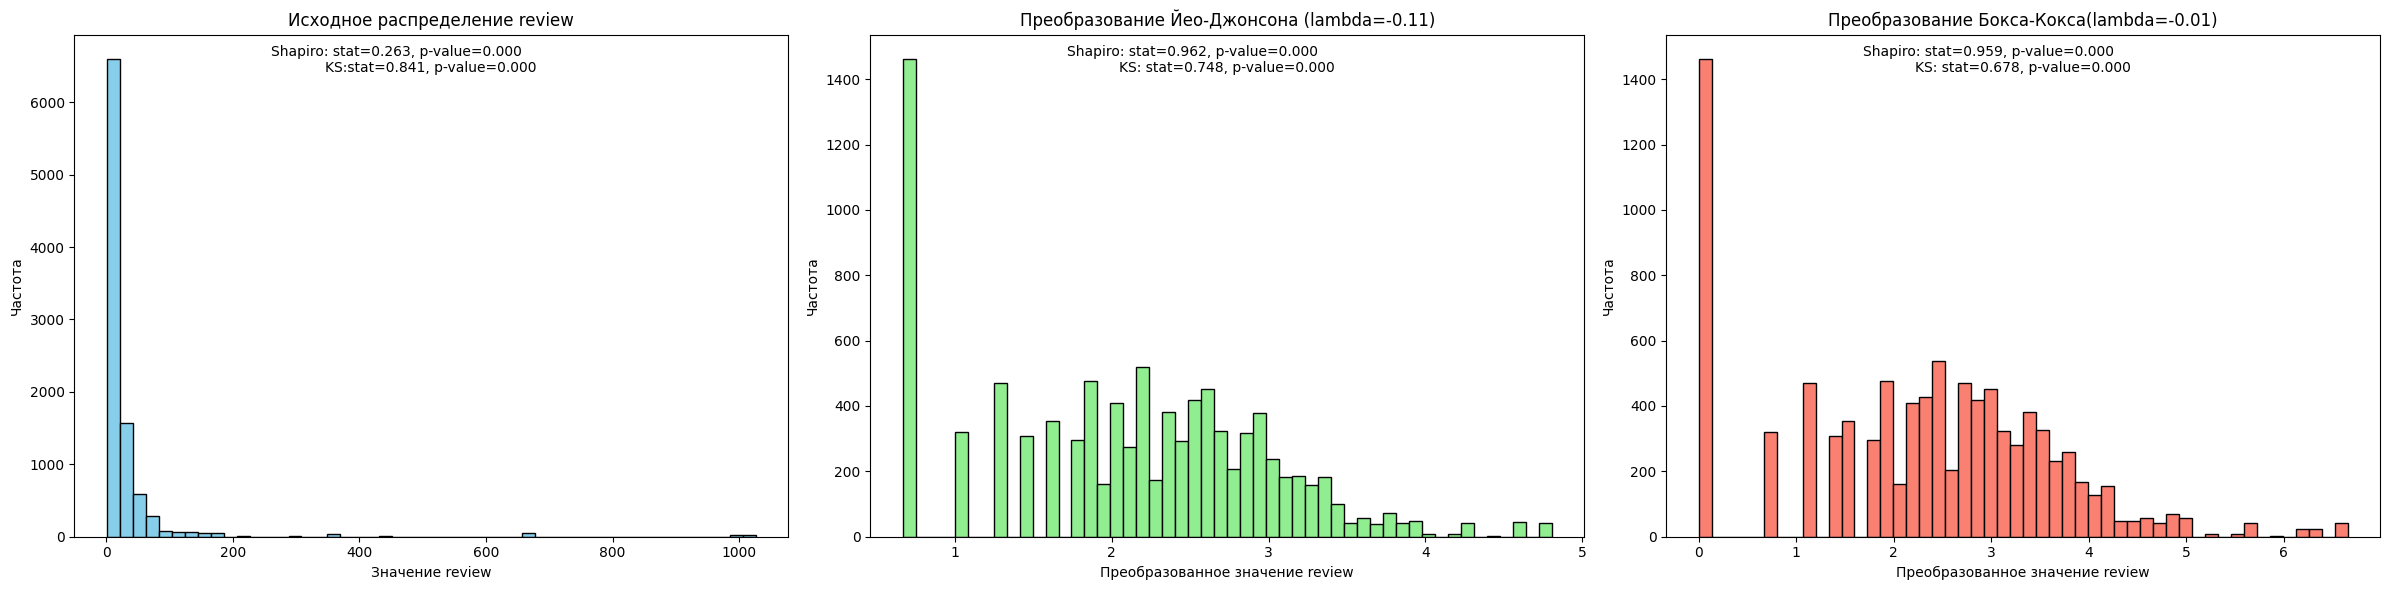

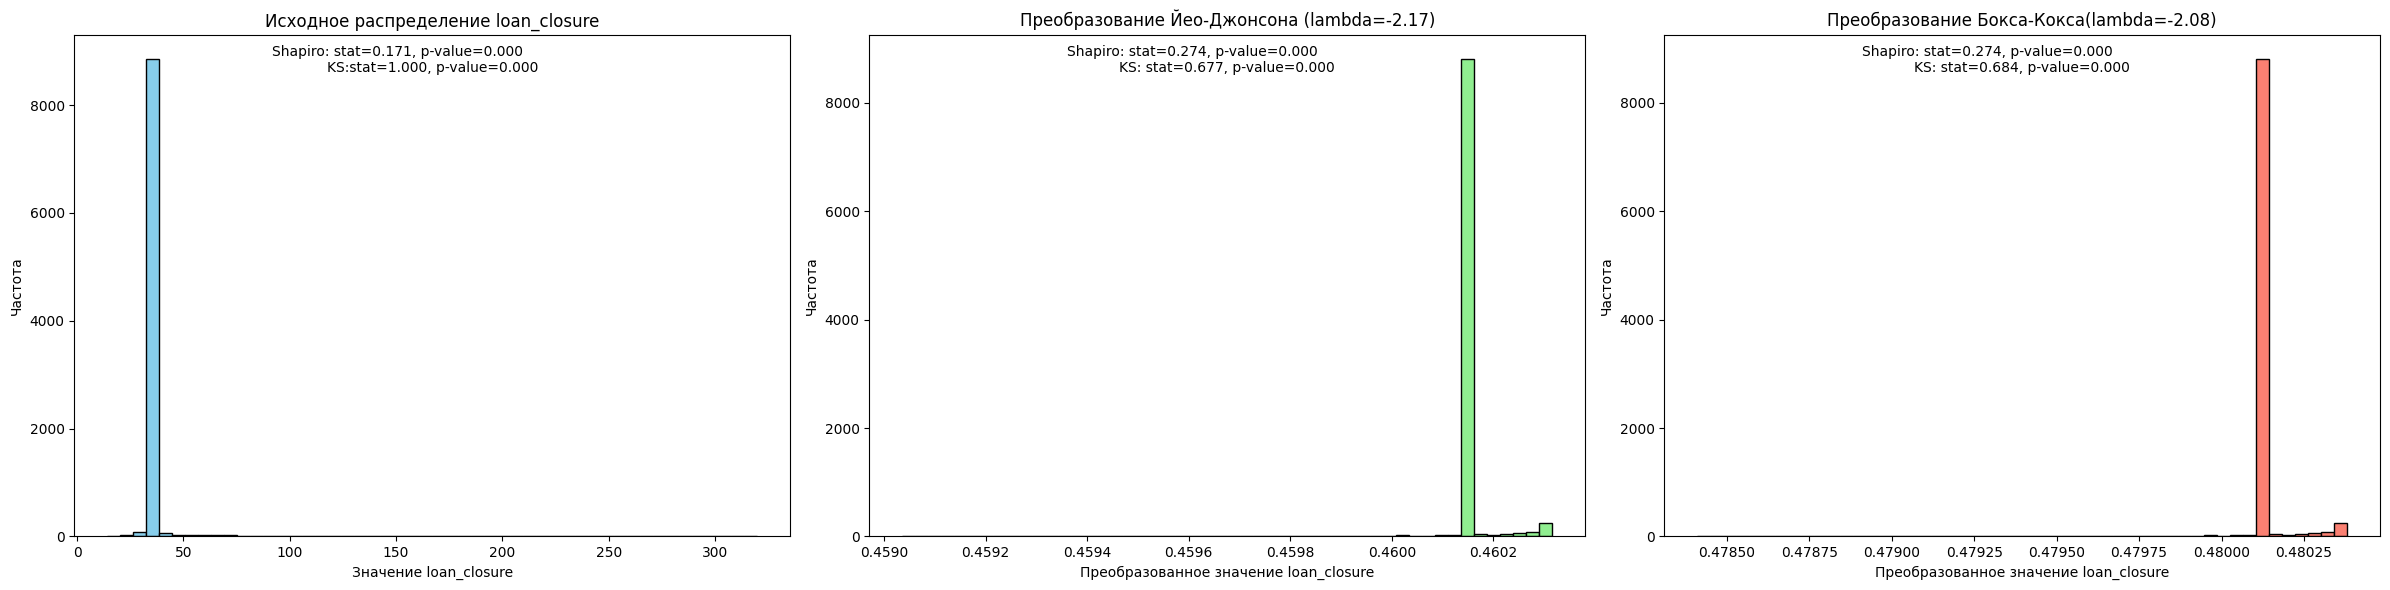

In [13]:
plot_transformed(df, metrics_list)

#### KDE распределение признаков

In [14]:
# Будем работать с популярными брендами
data = df[df["brands"].isin(brands)]

# Создание всех возможных комбинаций брендов ноутбука
brands_combinations = list(combinations(brands, 2))

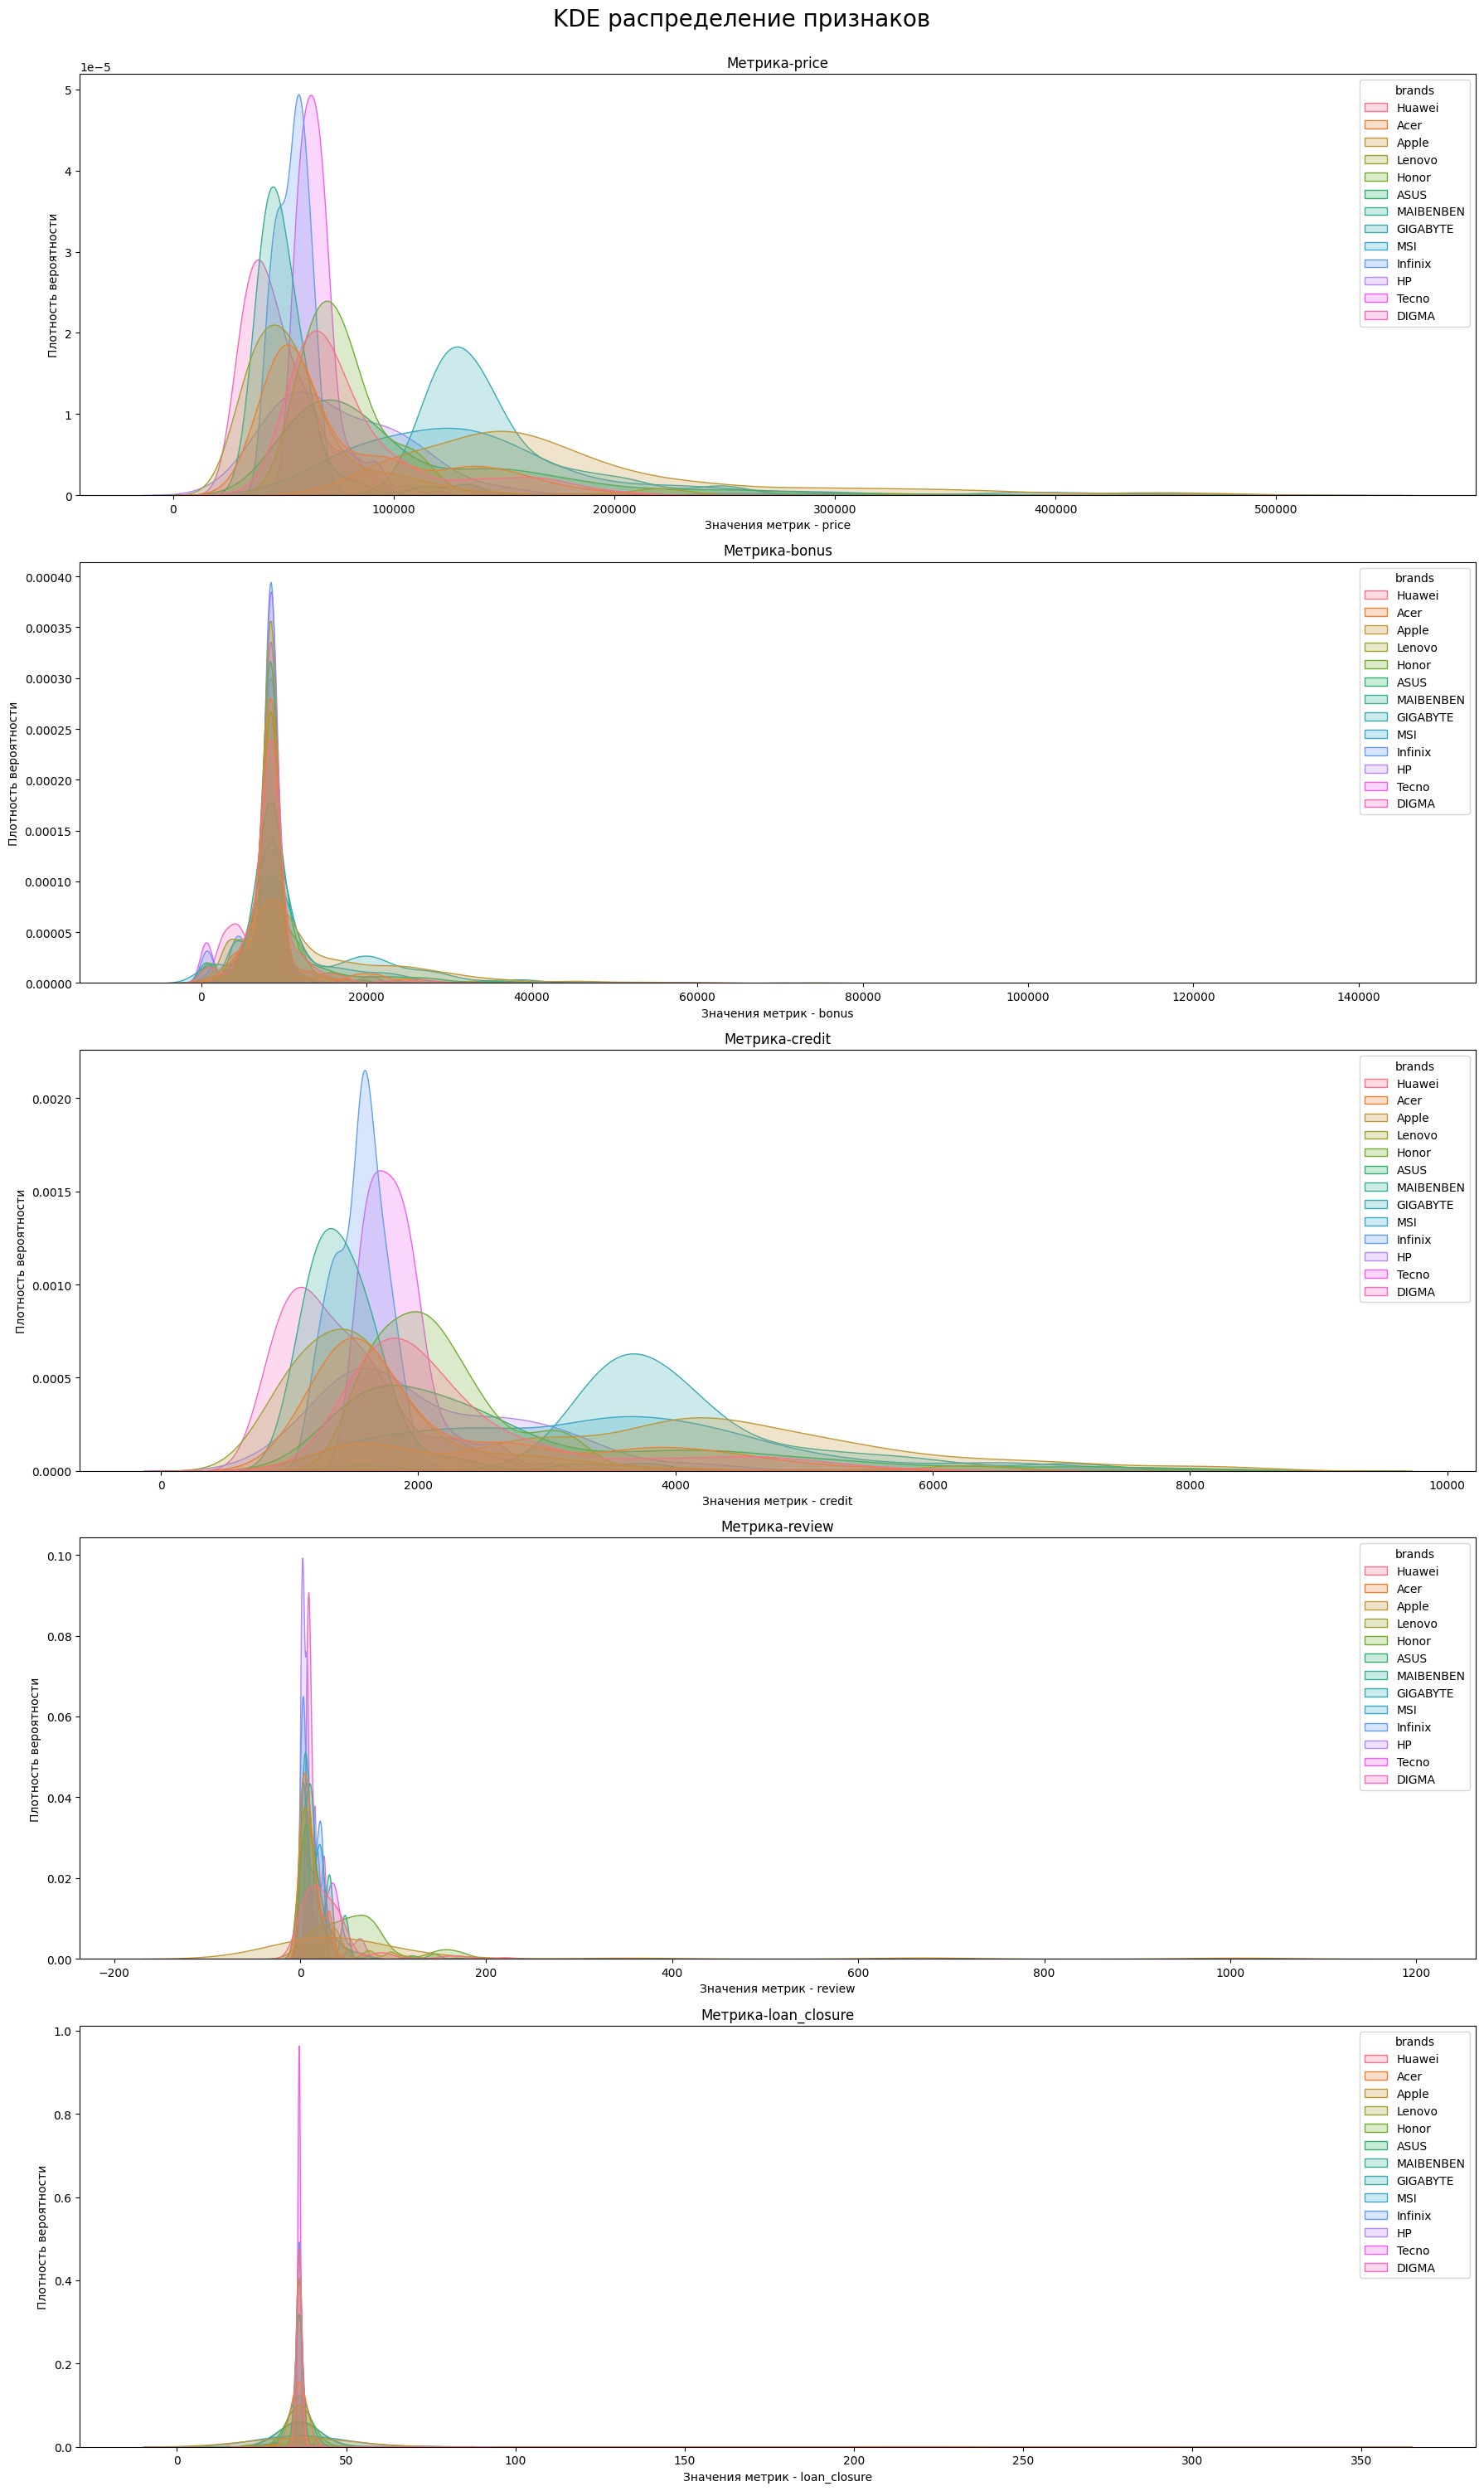

In [15]:
# KDE распределение признаков
plt.figure(figsize=(18, 30))
plt.suptitle("KDE распределение признаков", fontsize=20, x=0.5, y=1)

for i, column in enumerate(metrics_list):
    plt.subplot(len(metrics_list), 1, i + 1)
    sns.kdeplot(data=data, x=column, shade=True, hue="brands", common_norm=False)
    plt.title(f"Метрика-{column}")
    plt.xlabel(f"Значения метрик - {column}")
    plt.ylabel(f"Плотность вероятности")
    plt.tight_layout()

#### Тесты на нормальность данных

In [16]:
for metric in metrics_list:
    print(f"\nТест Шапиро-Уилка и Колмогорова-Смирнова для {metric}")

    for brand in brands:
        brand_data = data[data["brands"] == brand][metric]
        stat_shapiro, p_value_shapiro = shapiro(brand_data)
        stat_kstest, p_value_kstest = kstest(brand_data, "norm")

        if p_value_shapiro > 0.5:
            print(f"Shapiro - Принята: stat={stat_shapiro:.3f}, p-value={p_value_shapiro:.3f}")

        if p_value_kstest > 0.5:
            print(f"KS -      Принята: stat={stat_kstest:.3f}, p-value={p_value_kstest:.3f}")


Тест Шапиро-Уилка и Колмогорова-Смирнова для price

Тест Шапиро-Уилка и Колмогорова-Смирнова для bonus

Тест Шапиро-Уилка и Колмогорова-Смирнова для credit

Тест Шапиро-Уилка и Колмогорова-Смирнова для review

Тест Шапиро-Уилка и Колмогорова-Смирнова для loan_closure


In [17]:
## Тест Колмогорова-Смирнова для распределения данных между брендами для каждой метрики

metric_significant_ks2samp = []  # для хранения статистически значимых брендов для всех метрик

# Проведение теста Колмогорова-Смирнова для каждой метрики и каждой комбинации недель
for metric in metrics_list:

    print(f"\nТест Колмогорова-Смирнова для метрики {metric}:")
    count_ks2samp = 0
    significant_weeks_ks2samp = []

    for brand_combination in brands_combinations:

        brand1_data = data[data["brands"] == brand_combination[0]][metric]
        brand2_data = data[data["brands"] == brand_combination[1]][metric]

        # Проведение теста
        statistic, p_value = ks_2samp(brand1_data, brand2_data)

        # Вывод результатов
        if p_value > 0.05:
            print(
                f"Отклонение в распределении {metric} между брендами {brand_combination} статистически незначимо (p-value: {p_value:.4f})"
            )

            count_ks2samp += 1
            # добавляем стат значимые разлчия между неедлями в список
            significant_weeks_ks2samp.append(brand_combination)
        else:
            pass
            # print(f"Распределение {metric} между неделями {week_combination} не отличается статистически (p-value: {p_value:.4f}).")

    # Сохраняем статистически значимые недели для текущей метрики
    metric_significant_ks2samp.append(significant_weeks_ks2samp)


Тест Колмогорова-Смирнова для метрики price:

Тест Колмогорова-Смирнова для метрики bonus:
Отклонение в распределении bonus между брендами ('Lenovo', 'Tecno') статистически незначимо (p-value: 0.1334)
Отклонение в распределении bonus между брендами ('Lenovo', 'MAIBENBEN') статистически незначимо (p-value: 0.4558)
Отклонение в распределении bonus между брендами ('Lenovo', 'Infinix') статистически незначимо (p-value: 0.4683)
Отклонение в распределении bonus между брендами ('Lenovo', 'HP') статистически незначимо (p-value: 0.0616)
Отклонение в распределении bonus между брендами ('Lenovo', 'DIGMA') статистически незначимо (p-value: 0.2542)
Отклонение в распределении bonus между брендами ('Acer', 'Huawei') статистически незначимо (p-value: 0.1422)
Отклонение в распределении bonus между брендами ('Acer', 'HP') статистически незначимо (p-value: 0.7025)
Отклонение в распределении bonus между брендами ('Acer', 'Honor') статистически незначимо (p-value: 0.3752)
Отклонение в распределении bonus 

#### PSI

In [18]:
# Подсчет метрики PSI
for metric in metrics_list:
    print(f"\nPSI для {metric}:")

    for brand_combination in brands_combinations:

        brand1_data = data[data["brands"] == brand_combination[0]][metric]
        brand2_data = data[data["brands"] == brand_combination[1]][metric]

        psi_value = calculate_psi(brand1_data, brand2_data)[0]

        if psi_value < 0.25:
            print(
                f"Изменения являются умеренными между {brand_combination} брендами: KSI={psi_value:.4f}"
            )

        # print(f"PSI: {psi_brand:.4f} для метрики {metric} брендов {brand_combination}")


PSI для price:
Изменения являются умеренными между ('ASUS', 'Apple') брендами: KSI=0.0022
Изменения являются умеренными между ('ASUS', 'Lenovo') брендами: KSI=0.0002
Изменения являются умеренными между ('ASUS', 'Acer') брендами: KSI=0.0001
Изменения являются умеренными между ('ASUS', 'Huawei') брендами: KSI=0.0002
Изменения являются умеренными между ('ASUS', 'GIGABYTE') брендами: KSI=0.0002
Изменения являются умеренными между ('ASUS', 'MSI') брендами: KSI=0.0000
Изменения являются умеренными между ('ASUS', 'Tecno') брендами: KSI=0.0099
Изменения являются умеренными между ('ASUS', 'MAIBENBEN') брендами: KSI=0.0009
Изменения являются умеренными между ('ASUS', 'Infinix') брендами: KSI=0.0002
Изменения являются умеренными между ('ASUS', 'HP') брендами: KSI=0.0005
Изменения являются умеренными между ('ASUS', 'Honor') брендами: KSI=0.0011
Изменения являются умеренными между ('ASUS', 'DIGMA') брендами: KSI=0.0002
Изменения являются умеренными между ('Apple', 'Lenovo') брендами: KSI=0.0015
Из

#### Выводы:

1. По результатам анализа описательной статистики ноутбуков были выявлены следующие выводы:

    - Бренд ASUS занимает лидирующее положение на рынке, составляя около 23.5% от общего объема. Среди наиболее распространенных производителей ноутбуков выделяются компании Apple (18%), Huawei (15%) и Lenovo (10%).


    - Отмечается, что основной доля продаж осуществляется через платформу Ситилинк.
    
    - На рынке присутствуют ноутбуки, стоимость которых достигает около 0.5 миллиона рублей.

    - В среднем, покупателям предоставляется возможность получить кэшбэк в размере 800 рублей, что эквивалентно примерно 1% от стоимости ноутбука.

    - Обнаружены продавцы, количество отзывов которых превышает 1000, что существенно выше медианного значения в 50 отзывов, что может свидетельствовать о возможном наличии фальсификации отзывов.

    - Средний срок выплаты кредита составляет 3 года, при ежемесячном платеже в размере 2100 рублей.


<br>



2. По результатам анализа распределения признаков ноутбуков выявлены следующие выводы:

    - Наблюдаются аномальные объекты с большими значениями признаков, которые, тем не менее, отражают реальные характеристики ноутбуков.

    - Распределение признаков в зависимости от бренда ноутбука значительно различается. Анализ распределения с помощью метода ядерной оценки плотности (KDE) показывает различия в центре (среднем), наличие различных пиков и хвостов.

    - Общее распределение признаков не соответствует нормальному распределению, что подтверждается статистическими тестами Шапиро-Уилка и Колмогорова-Смирнова. Каждый признак имеет тяжелые хвосты как слева, так и справа.

    - Попытки преобразовать распределения признаков с помощью двух часто используемых методов, таких как преобразование Йео-Джонсона и Бокса-Кокса, не привели к достижению нормального распределения, как показали статистические тесты.

    - Между признаками цены (price), кредита (credit) и отзывов (review) выявлено статистически значимое попарное распределение между ноутбуками различных брендов. Однако для некоторых пар брендов распределение бонусов (bonus) оказалось не статистически значимым. Анализ времени погашения кредита (loan_closure) показал, что это время практически не зависит от бренда ноутбука и слабо зависит от его цены.

    - Анализ сдвига информационного критерия PSI показал, что изменения в признаках цены, кредита и отзывов являются умеренными, в то время как для других признаков наблюдается значительное смещение в распределении. Данный показатель слабо коррелирует с результатами тестов Шапиро-Уилка и Колмогорова-Смирнова.
 




In [19]:
data.head()

,price,bonus,credit,title,review,merchant_name,brands,manufacturer,loan_closure
0,79990.0,11999.0,2273.0,Ноутбук Huawei MateBook B3-520 Gray (53013fcn),17.0,Мегамаркет Москва Пушкино,Huawei,Мегамаркет,36
1,118202.0,17731.0,3359.0,Ноутбук Acer Nitro 5 AN515-58 Black (NH.QLZCD....,10.0,Мегамаркет Москва Томилино,Acer,Мегамаркет,36
2,94990.0,14249.0,2700.0,"Ноутбук Apple MacBook Air 13"" M1/8Gb/256Gb/Spa...",999.0,Мегамаркет Москва Пушкино,Apple,Мегамаркет,36
3,40990.0,2870.0,1165.0,Ноутбук Lenovo IdeaPad Slim 3 15IRU8 Gray,97.0,Ситилинк Москва Доставка,Lenovo,Ситилинк,36
4,51490.0,8239.0,1463.0,Ноутбук Honor MagicBook X16 2024 DOS Gray (530...,71.0,Click & Buy (со склада МегаМаркет),Honor,Click,36


### 2. Гипотезы касательно разницы сегментов ноутбуков 

Гипотезы:

1. **Гипотеза о различии кэшбэка между брендами ноутбуков**
    - $H_0$: Средний кэшбэк для покупателя одинаков для всех брендов ноутбуков.
    - $H_1$: Средний кэшбэк для покупателя различается в зависимости от бренда ноутбука.

    Эта гипотеза важна для определения, есть ли статистически значимые различия в кэшбэке для разных брендов ноутбуков. Это может помочь определить, имеют ли разные бренды стратегии ценообразования или маркетинговые акции.
<br>

2. **Гипотеза о влиянии бренда на цену ноутбуков**
    - $H_0$: Средняя цена ноутбуков не зависит от их производителя.
    - $H_1$: Средняя цена ноутбуков зависит от производителя.

    Эта гипотеза важна для выявления возможных различий в ценообразовании между производителями ноутбуков. Это может указать на особенности брендинга, качества или другие факторы, влияющие на цену.
<br>


3. **Гипотеза о взаимосвязи между ценой и количеством отзывов на ноутбук:**\
   - $H_0$: Нет статистически значимой корреляции между ценой и количеством отзывов ноутбуков.
   - $H_1$: Существует статистически значимая отрицательная корреляция между ценой и рейтингом ноутбуков, что указывает на то, что более дорогие ноутбуки имеют более низкий рейтинг.

   Эта гипотеза позволяет выяснить, есть ли связь между ценой и рейтингом ноутбуков, что может быть полезно для определения эффективности ценовой политики и маркетинговых стратегий.



Используемые пост-хок тесты в данной работе:

1. **Тест Тьюки (Tukey's HSD)**: Этот тест определяет различия между всеми парами групп. Он хорошо подходит для ситуаций, когда нужно контролировать общий уровень ошибки при множественном сравнении.

2. **Тест Шеффе (Scheffé's Test)**: Этот тест более консервативен и широко используется, когда групп много и/или размер выборки внутри групп неравномерен.

3. **Тест Бонферрони (Bonferroni Correction)**: Этот метод контролирует общий уровень ошибки при множественном сравнении путем уменьшения альфа-уровня значимости.


1. **Гипотеза о различии кэшбэка между брендами ноутбуков**
    - $H_0$: Средний кэшбэк для покупателя одинаков для всех брендов ноутбуков.
    - $H_1$: Средний кэшбэк для покупателя различается в зависимости от бренда ноутбука.

In [20]:
# тестирование для совокупности
res_stats_test_data = stats_test_data(data, "brands", "bonus")


# бутстрапирование и применение тестов 
res_bootstrap_list, res_groups_test = calculate_bootstrap_and_tests(
    data, brands_combinations, "bonus"
)

# множественное тестирование с поправкой на p_value
result_tukey = tukeyhsd_test(data, "bonus", "brands")
result_scheffe = scheffe_test(data, "bonus", "brands")

In [21]:
res_stats_test_data

{'f_oneway': (106.28697863953403, 1.9929734068256628e-247),
 'kruskal': (1040.7183374196188, 3.2915790684649603e-215),
 'alexandergovern': (957.4176708667084, 2.6614641807884226e-197)}

In [22]:
print_bootstrap_comparison(res_bootstrap_list)

   Bootstrap results for mean difference with 95% confidence    
 group1    group2    std_error   lower        upper       reject
----------------------------------------------------------------
ASUS       Apple      369.531    -5169.325    -3742.142    True      
ASUS       Lenovo     190.798    2158.520     2926.894     True      
ASUS       Acer       207.317    1059.395     1867.421     True      
ASUS       Huawei     210.327    1316.820     2148.690     True      
ASUS       GIGABYTE   367.255    -3925.965    -2466.997    True      
ASUS       MSI        338.915    -474.491     839.969      False     
ASUS       Tecno      207.506    2503.523     3301.547     True      
ASUS       MAIBENBEN  224.455    2446.724     3326.022     True      
ASUS       Infinix    202.541    2658.157     3421.721     True      
ASUS       HP         239.806    1455.205     2415.906     True      
ASUS       Honor      237.243    1735.266     2667.386     True      
ASUS       DIGMA      219.363    27

In [23]:
print_tests_summary(res_groups_test)

The results of testing hypotheses with various tests, FWER=0.05
 group1    group2     MWU      Perm   T-test    F-oneway:
----------------------------------------------------------------
ASUS       Apple      False    False    False    False   
ASUS       Lenovo     False    False    False    False   
ASUS       Acer       False    False    False    False   
ASUS       Huawei     False    False    False    False   
ASUS       GIGABYTE   False    False    False    False   
ASUS       MSI        True     True     True     True    
ASUS       Tecno      False    False    False    False   
ASUS       MAIBENBEN  False    False    False    False   
ASUS       Infinix    False    False    False    False   
ASUS       HP         False    False    False    False   
ASUS       Honor      False    False    False    False   
ASUS       DIGMA      False    False    False    False   
Apple      Lenovo     False    False    False    False   
Apple      Acer       False    False    False    False   
A

In [24]:
print_scheffe_test(result_scheffe)

The results of multiple testing using the Schaeffer method, FWER=0.05
 group1    group2     stat      pval      pval_corr    reject
----------------------------------------------------------------
ASUS       Acer       6.0557     0.0        0.0        True      
ASUS       Apple      -13.7688   0.0        0.0        True      
ASUS       DIGMA      6.6796     0.0        0.0        True      
ASUS       GIGABYTE   -9.4333    0.0        0.0        True      
ASUS       HP         4.6117     0.0        0.0003     True      
ASUS       Honor      4.8289     0.0        0.0001     True      
ASUS       Huawei     6.5255     0.0        0.0        True      
ASUS       Infinix    7.4935     0.0        0.0        True      
ASUS       Lenovo     10.9932    0.0        0.0        True      
ASUS       MAIBENBEN  7.1238     0.0        0.0        True      
ASUS       MSI        0.7204     0.4714     1.0        False     
ASUS       Tecno      8.0259     0.0        0.0        True      
Acer       

In [25]:
print(result_tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
  group1    group2   meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------
     ASUS      Acer -1484.6958    0.0 -2304.0485  -665.3431   True
     ASUS     Apple  4415.9008    0.0    3635.01  5196.7917   True
     ASUS     DIGMA -3162.2694    0.0  -4627.827 -1696.7117   True
     ASUS  GIGABYTE  3163.3392    0.0  2213.7264   4112.952   True
     ASUS        HP -1968.4039 0.0001 -3297.3841  -639.4237   True
     ASUS     Honor -2182.0345    0.0 -3583.6611  -780.4079   True
     ASUS    Huawei -1757.3886    0.0  -2639.318  -875.4593   True
     ASUS   Infinix -3038.0378    0.0 -4313.4622 -1762.6134   True
     ASUS    Lenovo -2556.7804    0.0 -3359.1389 -1754.4219   True
     ASUS MAIBENBEN -2851.4545    0.0 -4108.9098 -1593.9992   True
     ASUS       MSI  -238.5234 0.9999 -1224.4497   747.4029  False
     ASUS     Tecno -2873.8131    0.0 -4016.8342  -1730.792   

Figure(1000x600)


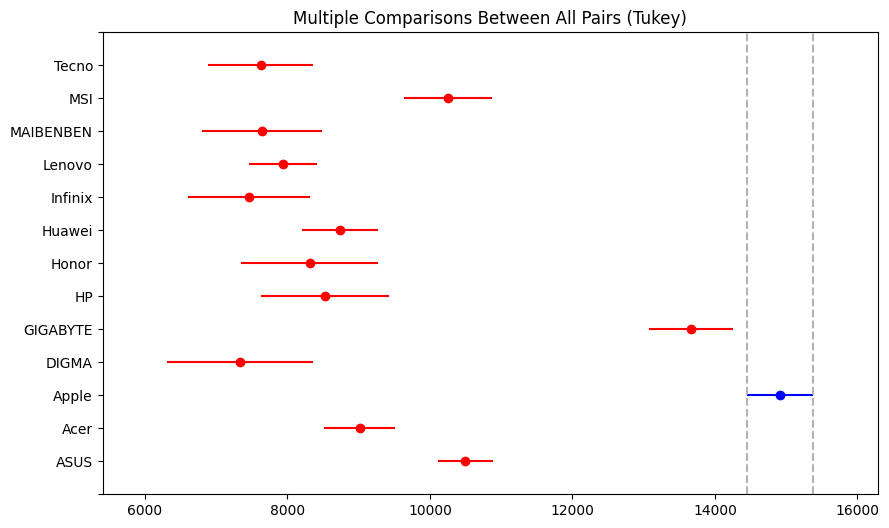

In [26]:
print(result_tukey.plot_simultaneous(comparison_name="Apple"))

#### Выводы по первой гипотезе:

1. В ходе всех проведенных тестов было выявлено статистически значимое различие в средних значениях бонуса (кэшбека) между различными брендами.

2. Метод бутсрапа выявил минимальное количество пар брендов, у которых средние значения распределения цен одинаковы. Эти пары также подтверждаются другими статистическими тестами и методами.

3. При анализе результатов второго метода с поправкой Банферони для тестов (манна-уитни, Пермутационный, t-критерий Стьюдента и ANOVA) было замечено, что тесты манна-уитни не полностью согласуются с результатами других методов.

4. Метод Шеффе значительно скорректировал значения p-value, что может указывать на его высокую корректирующую способность.

5. Метод Tukey выявил наибольшее количество пар с одинаковым средним кэшбэком. Согласно результатам Tukey, средний кэшбэк на продукцию для брендов GIGABYTE и Apple является самым высоким (соответственно 14 и 15 тыс.), и эти значения не пересекаются с другими брендами.

6. Также можно сделать вывод о том, что между некоторыми брендами существует минимальная разница в средней цене:

- Infinix и MAIBENBEN: meandiff=186.5833 (p-value = 1.0)
- Infinix и Tecno: meandiff=164.2247 (p-value = 1.0)
- MAIBENBEN и Tecno: meandiff=-22.3586 (p-value = 1.0)
- HP и Honor: meandiff=-213.6306 (p-value = 1.0)
- HP и Huawei: meandiff=211.0153 (p-value = 1.0)


В целом, проведенный анализ демонстрирует наличие статистически значимых различий между средними значениями в большинстве пар групп, что указывает на значимость этих различий при сравнении параметров, изучаемых в каждой группе.

2. **Гипотеза о влиянии бренда на цену ноутбуков**
    - $H_0$: Средняя цена ноутбуков не зависит от их производителя.
    - $H_1$: Средняя цена ноутбуков зависит от производителя.

In [27]:
# тестирование для совокупности
res_2_stats_test_data = stats_test_data(data, "brands", "price")


# бутстрапирование и применение тестов для совокупности популяции
res_2_bootstrap_list, res_2_groups_test = calculate_bootstrap_and_tests(
    data, brands_combinations, "price"
)

# множественное тестирование с поправкой на p_value
result_tukey_2 = tukeyhsd_test(data, "price", "brands")
result_scheffe_2 = scheffe_test(data, "price", "brands")

In [28]:
res_2_stats_test_data

{'f_oneway': (425.18795267804364, 0.0),
 'kruskal': (4348.208310422168, 0.0),
 'alexandergovern': (4416.836589843222, 0.0)}

In [29]:
print_bootstrap_comparison(res_2_bootstrap_list)

   Bootstrap results for mean difference with 95% confidence    
 group1    group2    std_error   lower        upper       reject
----------------------------------------------------------------
ASUS       Apple      2837.032   -76795.619   -65717.331   True      
ASUS       Lenovo     1827.967   42893.168    50287.772    True      
ASUS       Acer       1961.313   24766.446    32448.267    True      
ASUS       Huawei     1852.024   20437.487    27591.564    True      
ASUS       GIGABYTE   2069.940   -42949.875   -34763.131   True      
ASUS       MSI        3377.451   -42122.772   -29208.244   True      
ASUS       Tecno      1467.716   39106.118    44713.723    True      
ASUS       MAIBENBEN  1728.570   51547.403    58083.894    True      
ASUS       Infinix    1464.844   50464.967    56301.939    True      
ASUS       HP         3058.280   19597.535    32066.290    True      
ASUS       Honor      2050.533   25169.716    33237.485    True      
ASUS       DIGMA      1722.961   56

In [30]:
print_tests_summary(res_2_groups_test)

The results of testing hypotheses with various tests, FWER=0.05
 group1    group2     MWU      Perm   T-test    F-oneway:
----------------------------------------------------------------
ASUS       Apple      False    False    False    False   
ASUS       Lenovo     False    False    False    False   
ASUS       Acer       False    False    False    False   
ASUS       Huawei     False    False    False    False   
ASUS       GIGABYTE   False    False    False    False   
ASUS       MSI        False    False    False    False   
ASUS       Tecno      False    False    False    False   
ASUS       MAIBENBEN  False    False    False    False   
ASUS       Infinix    False    False    False    False   
ASUS       HP         False    False    False    False   
ASUS       Honor      False    False    False    False   
ASUS       DIGMA      False    False    False    False   
Apple      Lenovo     False    False    False    False   
Apple      Acer       False    False    False    False   
A

In [31]:
print_scheffe_test(result_scheffe_2)

The results of multiple testing using the Schaeffer method, FWER=0.05
 group1    group2     stat      pval      pval_corr    reject
----------------------------------------------------------------
ASUS       Acer       12.6454    0.0        0.0        True      
ASUS       Apple      -27.0822   0.0        0.0        True      
ASUS       DIGMA      14.0112    0.0        0.0        True      
ASUS       GIGABYTE   -14.4445   0.0        0.0        True      
ASUS       HP         6.7545     0.0        0.0        True      
ASUS       Honor      7.2347     0.0        0.0        True      
ASUS       Huawei     9.8195     0.0        0.0        True      
ASUS       Infinix    14.6588    0.0        0.0        True      
ASUS       Lenovo     21.4587    0.0        0.0        True      
ASUS       MAIBENBEN  15.2825    0.0        0.0        True      
ASUS       MSI        -11.4209   0.0        0.0        True      
ASUS       Tecno      13.009     0.0        0.0        True      
Acer       

In [32]:
print(result_tukey_2)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
  group1    group2    meandiff   p-adj     lower        upper     reject
------------------------------------------------------------------------
     ASUS      Acer  -28747.4617    0.0   -35583.286  -21911.6375   True
     ASUS     Apple   70973.8048    0.0   64458.8657   77488.7439   True
     ASUS     DIGMA  -59948.6043    0.0  -72175.6886  -47721.5201   True
     ASUS  GIGABYTE    38509.246    0.0   30586.6674   46431.8246   True
     ASUS        HP  -26683.4981    0.0  -37771.1228  -15595.8734   True
     ASUS     Honor  -29622.0303    0.0  -41315.7408  -17928.3199   True
     ASUS    Huawei   -23939.893    0.0  -31297.7918  -16581.9941   True
     ASUS   Infinix  -53503.5238    0.0  -64144.3346   -42862.713   True
     ASUS    Lenovo  -46718.4454    0.0  -53412.4882  -40024.4027   True
     ASUS MAIBENBEN  -55174.8517    0.0  -65665.7469  -44683.9565   True
     ASUS       MSI   35713.4723    0.0   27487.931

Figure(1000x600)


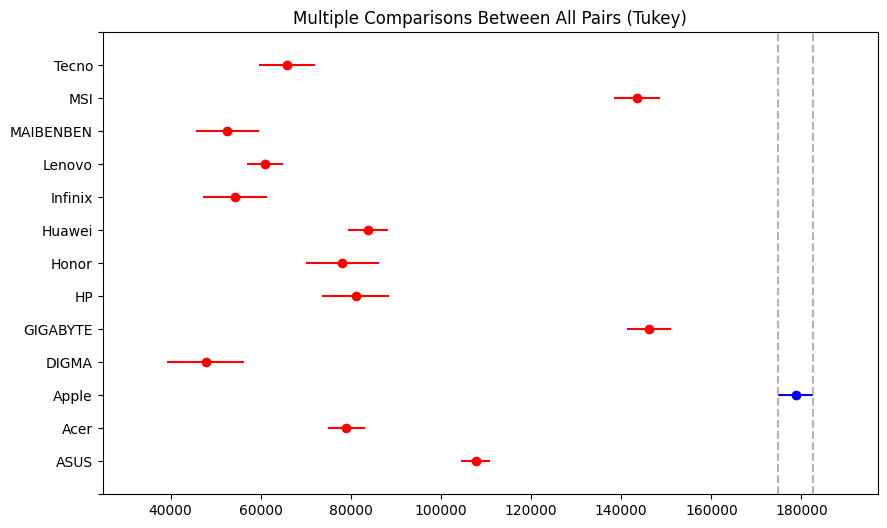

In [33]:
print(result_tukey_2.plot_simultaneous(comparison_name="Apple"))


#### Выводы по второй гипотезе:

1. Проведённое исследование выявило статистически значимые различия в средних ценах между различными брендами ноутбуков. Анализ данных показал, что некоторые бренды демонстрируют статистически значимые различия в цене по сравнению с другими брендами. Данные бренды имеют, одинаковую среднюю цену:

| Бренд 1   | Бренд 2   |
|-----------|-----------|
| Acer      | Honor     |
| Huawei    | HP        |
| GIGABYTE  | MSI       |
| MAIBENBEN | Infinix   |
| HP        | Honor     |


2. Метод Tukey выявил несколько пар брендов с одинаковыми средними ценами. Согласно результатам этого метода, средняя цена на продукцию брендов MSI, GIGABYTE и Apple оказалась наиболее высокой, составляя соответственно 150, 150 и 180 тысяч рублей.

3. Анализ показал, что большинство брендов предлагают ноутбуки с ценой, не превышающей 100 тысяч рублей. Однако, есть бренды, у которых средняя цена ноутбуков изменяется не более чем на 8 тысяч (например, ASUS, Lenovo, Huawei), в то время как у бренда DIGMA размах цен составляет около 20 тысяч рублей в среднем. Наибольшая разница в ценах наблюдается между брендами Apple и DIGMA(130 тыс руб).

Таким образом, проведённый анализ позволяет сделать вывод о наличии статистически значимых различий между средними ценами на ноутбуки различных брендов, что подчёркивает значимость этих различий при сравнении и анализе параметров, характеризующих каждый бренд.

3. **Гипотеза о взаимосвязи между ценой и количеством отзывов на ноутбук:**
   - $H_0$: Нет статистически значимой корреляции между ценой и количеством отзывов ноутбуков.
   - $H_1$: Существует статистически значимая отрицательная корреляция между ценой и рейтингом ноутбуков, что указывает на то, что более дорогие ноутбуки имеют более низкий рейтинг.

In [34]:
res_corr_test = correlation_tests_with_correction(data, "price", "review", "brands")
print_correlation_results(res_corr_test)

name       corr_stat  pval       pval_corr    reject    
--------------------------------------------------------
Huawei    
pearsonr   -0.299     5.61e-17   6.17e-16     True       
spearmanr  -0.489     1.99e-46   2.38e-45     True       
kendalltau -0.33      2.99e-40   3.58e-39     True       
--------------------------------------------------------
Acer      
pearsonr   -0.128     9.55e-05   0.000669     True       
spearmanr  -0.23      1.49e-12   1.2e-11      True       
kendalltau -0.158     6.42e-12   5.13e-11     True       
--------------------------------------------------------
Apple     
pearsonr   -0.382     2.22e-38   2.89e-37     True       
spearmanr  -0.624     1.73e-116  2.25e-115    True       
kendalltau -0.472     4.04e-115  5.25e-114    True       
--------------------------------------------------------
Lenovo    
pearsonr   -0.252     1.05e-15   1.05e-14     True       
spearmanr  -0.411     2.36e-41   2.59e-40     True       
kendalltau -0.284     2.26e-38   

### Вывод по третьей гипотезы:

Из предоставленных результатов проверки гипотезы о взаимосвязи между ценой и количеством отзывов на ноутбук можно сделать следующие выводы:

1. **Существует статистически значимая отрицательная корреляция**:
   - Для большинства брендов (Huawei, Acer, Apple, Lenovo, ASUS, MAIBENBEN, GIGABYTE, HP) наблюдается статистически значимая отрицательная корреляция между ценой и количеством отзывов на ноутбук. Это подтверждает альтернативную гипотезу $H_1$, которая предполагает, что более дорогие ноутбуки имеют меньше отзывов.

2. **Нет статистически значимой корреляции**:
   - Для некоторых брендов (Honor, MSI, Infinix, Tecno, DIGMA) не удалось обнаружить статистически значимой корреляции между ценой и количеством отзывов на ноутбук. Для этих случаев нулевая гипотеза $H_0$ остаётся в силе.

3. **Различные методы корреляции**:
   - Для большинства брендов результаты корреляции по методу Спирмена (spearmanr) и Пирсона (pearsonr) согласуются друг с другом. Однако, некоторые из них могут показывать различия в степени корреляции.

4. **Значимость корреляции**:
   - Значимость корреляции между ценой и количеством отзывов на ноутбук варьируется в зависимости от бренда. Например, для некоторых брендов (Apple, Lenovo, HP) наблюдается очень высокая статистическая значимость корреляции (p-value < 0.001), в то время как для других (например, Honor, MSI, Infinix, Tecno, DIGMA) корреляция не является статистически значимой.

Итак, основываясь на представленных данных, можно утверждать, что в целом существует отрицательная корреляция между ценой и количеством отзывов на ноутбук, но это не применимо ко всем брендам.